In [1]:
%reload_ext autoreload
%autoreload 2
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.io.wavfile as wv
import scipy.signal as sig
import wave

from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense

from util import util
from util import WavFileParts
from util.logUtil import LOG, LOG_HEADER
from util.confusionMatrix import ConfusionMatrix


Using TensorFlow backend.


### globale settings

In [2]:
classes = ['music', 'voice', 'environment']

macDir = '/Volumes/SAA_DATA/datasets/'
winDir = 'E:/SAA_DATA/'
osDir = winDir
recordingDir = osDir + '/localizationRecordings'

if osDir == winDir:
    storageFolder = 'E:/SAA_DATA/storedData/'
else:
    storageFolder = '/Users/etto/Desktop/storedData/'

baseSrcDir = osDir + 'localizationFiles/20171025AllExtractionsMic4'
orgWavDirs1 = ['G428_0.0_1.4',
              'G527_0.5_1.4',
              'Studio_2.0_4.2'
              ]

orgWavDirs2 = ['G428_2.1_2.4',
              'G527_1.2_5.8',
              'Studio_3.0_2.0'
              ]

orgsG428 = ['G428_0.0_1.4','G428_2.1_2.4']
orgsG527 = ['G527_0.5_1.4','G527_1.2_5.8']
orgsStudio = ['Studio_2.0_4.2','Studio_3.0_2.0']

NFFT = 1024

chunksBaseDir = 'chunks'
rooms = ['Studio', 'G428', 'G527']

### utility functies

In [3]:
def readSoundChunksDynamic(moduleString):
    chunks = importlib.import_module(moduleString).soundChunks
    wfPts = []
    for jsonString in chunks:
        wfPts.append(WavFileParts.WavFilePartFromJson(jsonString))
    return wfPts

def timeFunction(func):
    """
    Aanroep: bijv. fpc = timeFunction(lambda: getFilesPerCategory(srcDir))
    """
    startTime = datetime.now()
    print('Start: ' + startTime.strftime('%H:%M:%S') + '\n=================')

    res = func()
    
    endTime = datetime.now()
    print('\n=================\nEnd: ' + endTime.strftime('%H:%M:%S'))
    print('Time taken: '),
    print(endTime - startTime)
    print()
    
    return res
    
def storeTestData(allSpectros, allClasses, storageName, keyName):
    filename = storageFolder + storageName + '.hd5'
    df = pd.DataFrame(allSpectros)
    df.to_hdf(path_or_buf=filename, key='spectros_' + keyName)

    df = pd.DataFrame(allClasses)
    df.to_hdf(path_or_buf=filename, key='classes_' + keyName)

def retrieveTestData(storageName, keyName):
    filename = storageFolder + storageName + '.hd5'
    specDf = pd.read_hdf(path_or_buf=filename, key='spectros_' + keyName)
    classesDf = pd.read_hdf(path_or_buf=filename, key='classes_' + keyName)
    return specDf.values, classesDf.values
    

### functies tbv trainen

In [4]:
# Maakt een dictionary aan; per categorie alle files (volledig pad) uit de srcDir
# srcDir is een van de orgWavDirs, bijvoorbeeld
#    localizationFiles/20171025AllExtractionsMic4/G428_0.0_1.4
def getFilesPerCategory(srcDir):
    filesPerCategory = {}
    for catDirLong in glob.glob(srcDir + '/*'):
        catDir = catDirLong.replace('\\', '/')
        catDir = catDir.replace(srcDir + '/', '')

        filesPerCategory[catDir] = []
        for filename in glob.glob(catDirLong + '/*'):
            filename = filename.replace('\\','/')
            filesPerCategory[catDir].append(filename)
    return filesPerCategory

def getFilesPerCatFromMultipleDirs(srcDirs, srcDirsBase=''):
    filesPerCat = {}
    for dirName in srcDirs:
        srcDir = srcDirsBase + '/' + dirName
        fpcNw = getFilesPerCategory(srcDir)
        if not filesPerCat:
            filesPerCat = fpcNw
        else:
            for key in filesPerCat:
                filesPerCat[key] += fpcNw[key]
    return filesPerCat
        

In [5]:
# Maakt een dictionary aan; per categorie de spectrogrammen
def getSpectrosFromFilesPerCategory(filesPerCategory):
    spectros = {}
    for clz in classes:
        spectros[clz] = []
        for filename in filesPerCategory[clz]:
            fs, signal = wv.read(filename)
            freq_array, segment_times, spectrogram = sig.spectrogram(x=signal, fs=fs, nfft=NFFT, noverlap=0)
            spectros[clz].append(spectrogram.T)
    return spectros

In [6]:
def getClassLengths(spectrosPerCat):
    clzLengths = {}
    for clz in classes:
        clzLengths[clz] = sum([np.shape(lst)[0] for lst in spectrosPerCat[clz]])
    return clzLengths

In [7]:
# verwacht invoer van getSpectrosFromFilesPerCategory
# levert traindata op (X_train en Y_train)
def createTrainDataFromSpectros(spectrosPerCat, clzLengths):
    X_train = np.concatenate(spectrosPerCat[classes[0]], axis=0)
    for i in range(1, len(classes)):
        nwSpectros = np.concatenate(spectrosPerCat[classes[i]], axis=0)
        X_train = np.concatenate((X_train,nwSpectros), axis=0)
    
    # one-hot encoding voor Y_train
    nrFiles = clzLengths[classes[0]]
    Y_train = np.array((np.ones(nrFiles),np.zeros(nrFiles), np.zeros(nrFiles))).T

    nrFiles = clzLengths[classes[1]]
    Y_train_nw = np.array((np.zeros(nrFiles), np.ones(nrFiles), np.zeros(nrFiles))).T
    Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)

    nrFiles = clzLengths[classes[2]]
    Y_train_nw = np.array((np.zeros(nrFiles), np.zeros(nrFiles), np.ones(nrFiles))).T
    Y_train = np.concatenate((Y_train, Y_train_nw),axis=0)
    
    return X_train, Y_train

### deep learning model

In [8]:
def create_model(layersizes):
    # create model
    model = Sequential()
    model.add(Dense(layersizes[0], input_dim=513, activation='relu'))
    for lsize in layersizes[1:]:
        model.add(Dense(lsize, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
def getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs):
    modelFilename = modelFilePath + baseModelFilename
    for lsize in layers:
        modelFilename = '{}_{}'.format(modelFilename, lsize)
    modelFilename += 'ep{}'.format(nrEpochs)
    modelFilename += '.hd5'
    return modelFilename

In [10]:
def getModelName(baseModelFilename, layers, nrEpochs):
    modelFilename = baseModelFilename
    for lsize in layers:
        modelFilename = '{}_{}'.format(modelFilename, lsize)
    modelFilename += 'ep{}'.format(nrEpochs)
    return modelFilename

In [11]:
def train_model(X_train, Y_train, layers, nrEpochs, modelFilePath, baseModelFilename, batch_size=None):
    soundModel = create_model(layers)
    history = timeFunction(lambda: soundModel.fit(X_train,Y_train, epochs=nrEpochs, shuffle=True, verbose=1, batch_size=batch_size))
    soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))
    plt.plot(history.history['loss'])
    plt.show()

In [21]:
def train_and_evaluate_model(X_train, Y_train, realTrainClasses, layers, nrEpochs, modelFilePath, baseModelFilename, batch_size=None):
    soundModel = create_model(layers)
    history = timeFunction(lambda: soundModel.fit(X_train,Y_train, epochs=nrEpochs, shuffle=True, verbose=1, batch_size=batch_size))
    soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))
    plt.plot(history.history['loss'])
    plt.show()
    evaluate_model(X_train, realTrainClasses,layers, nrEpochs, modelFilePath, baseModelFilename)

In [13]:
def evaluate_model(X_test, realClasses, layers, nrEpochs, modelFilePath, baseModelFilename):
    soundModel = load_model(getModelFileName(modelFilePath, baseModelFilename, layers, nrEpochs))

    # predicted classes
    predictions = soundModel.predict(X_test)
    predClasses = predictions.argmax(axis=1)

    matrix = ConfusionMatrix(classes)
    for vals in zip(realClasses, predClasses):
        matrix.add(int(vals[0]), int(vals[1]), 1)
    LOG(matrix.toString(),True)
    LOG('', True)
    LOG(matrix.toF1String(), True)
    return matrix

In [14]:
def train_and_evaluate_per_epoch(X_train, Y_train, realClasses, layers, nrEpochs, modelFilePath, baseModelFilename, batch_size=None):
    soundModel = create_model(layers)
    for epNr in range(1, nrEpochs+1):
        LOG('\n*****************\n* Epoch nr {}\n*****************\n'.format(epNr), True)
        soundModel.fit(X_train,Y_train, epochs=1, shuffle=True, verbose=1, batch_size=batch_size)
        soundModel.save(getModelFileName(modelFilePath, baseModelFilename, layers, epNr))
        evaluate_model(X_train, realClasses, layers, epNr, modelFilePath, baseModelFilename)

### functies tbv testen

In [15]:
def createAndStoreTestData(wavFileParts, baseDir, fileDate, micNr, storeFilename, keyName):
    allSpectros = np.array([])
    allClasses = np.array([])

    for wfPt in wavFileParts: #type: WavFilePart
        if not 'Gunshot' in wfPt.getSoundType():
            filename = baseDir + '/{:d}_{:d}_mono{:d}.wav'.format(fileDate, wfPt.fileNr, micNr)
            fs, signal = wv.read(filename)

            classNr = classes.index(wfPt.getSoundType().lower())
            for soundChunk in wfPt.getSoundChunks(micNr):
                startFrame = int(soundChunk[0] * fs)
                endFrame = int(soundChunk[1] * fs)

                sigChunk = signal[startFrame: endFrame]
                freq_array, segment_times, spectrogram = sig.spectrogram(x=sigChunk, fs=fs, nfft=NFFT, noverlap=0)
                if len(allSpectros) == 0:
                    allSpectros = spectrogram.T
                else:
                    allSpectros = np.append(allSpectros, spectrogram.T, axis=0)
                allClasses = np.append(allClasses, classNr * np.ones(len(segment_times)))
                
    storeTestData(allSpectros, allClasses, storeFilename, keyName)


In [16]:
def getTrainDataFromFolders(orgWavDirs):
    fpc = getFilesPerCatFromMultipleDirs(orgWavDirs, baseSrcDir)
    spcs = getSpectrosFromFilesPerCategory(fpc)
    clzLengths = getClassLengths(spcs)
    X_train, Y_train = createTrainDataFromSpectros(spcs, clzLengths)
    # real train classes
    realTrainClasses = np.concatenate((np.zeros(clzLengths[classes[0]]), 
                                  np.ones(clzLengths[classes[1]]), 
                                  2*np.ones(clzLengths[classes[2]])))
    return X_train, Y_train, realTrainClasses


In [17]:
def testModellen(modelFilePath, layerss, micNr, testFileNames, showOverall=True):

    # test data
    keyname = 'mic{}'.format(micNr)

    for layers in layerss:
        for nrEpochs in nrsEpochs:
            overallMatrix = ConfusionMatrix(classes)
            for testFileName in testFileNames:
                testSpecs, testClasses = retrieveTestData(testFileName, keyname)

                LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                           + '\n# ' + keyname
                           + '\n# ' + testFileName,
                           True)
                matrix = evaluate_model(testSpecs, testClasses, layers, nrEpochs, modelFilePath, baseModelFilename)
                overallMatrix.addMatrix(matrix.normalizedCopy())
            
            if showOverall:
                overallMatrix = overallMatrix.normalizedCopy()
                LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                           + '\n# ' + keyname
                           + '\n# ' + 'testData_Overall',
                           True)
                LOG(overallMatrix.toString(),True)
                LOG('', True)
                LOG(overallMatrix.toF1String(), True)

In [28]:
def testModel(modelFilePath, layers, micNr, testFileNames, nrEpochs, showOverall=True):

    # test data
    keyname = 'mic{}'.format(micNr)

    overallMatrix = ConfusionMatrix(classes)
    for testFileName in testFileNames:
        testSpecs, testClasses = retrieveTestData(testFileName, keyname)

        LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                   + '\n# ' + keyname
                   + '\n# ' + testFileName,
                   True)
        matrix = evaluate_model(testSpecs, testClasses, layers, nrEpochs, modelFilePath, baseModelFilename)
        overallMatrix.addMatrix(matrix.normalizedCopy())

    if showOverall:
        overallMatrix = overallMatrix.normalizedCopy()
        LOG_HEADER(getModelName(baseModelFilename, layers, nrEpochs) 
                   + '\n# ' + keyname
                   + '\n# ' + 'testData_Overall',
                   True)
        LOG(overallMatrix.toString(),True)
        LOG('', True)
        LOG(overallMatrix.toF1String(), True)

### trainen van model obv: G428 en G527

In [18]:
# Train voor alle lagen
baseModelFilename = '20180829_speedTest'
modelFilePath = storageFolder
logPrefix = 'Orgs G428 en G527'
orgWavDirs = orgsG428 + orgsG527
X_train, Y_train, realTrainClasses = getTrainDataFromFolders(orgWavDirs)

In [19]:
layersList = [[400, 250, 100, 20]]
nrEpochs = 1
nrsEpochs = range(1, nrEpochs + 1)
bSize = 2048

####################################
#
# Orgs G428 en G527, lagen: [400, 250, 100, 20]
#
####################################

Start: 13:10:27
Epoch 1/1
754329/754329 [==============================] - 6s 8us/step - loss: 0.2501 - acc: 0.9039

End: 13:10:33
Time taken: 
0:00:06.488364



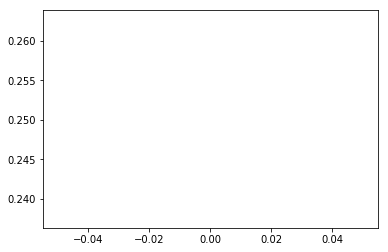

                   m       v       e |  sens   acc
music         221021   22231     394 |  0.91  0.97
voice           2852  232877    8518 |  0.95  0.95
environment      836    6359  259241 |  0.97  0.98
--------------------------------------
prec            0.98    0.89    0.97

F1 overall: 0.94
F1 music: 0.94
F1 voice: 0.92
F1 environment: 0.97



In [22]:
for layers in layersList:
    LOG_HEADER(logPrefix + ', lagen: {}'.format(str(layers)), True)
    train_and_evaluate_model(X_train, Y_train, realTrainClasses, 
                                 layers, nrEpochs, modelFilePath, baseModelFilename,
                                batch_size=bSize)

####################################
#
# Orgs G428 en G527, lagen: [400, 250, 100, 20]
#
####################################

Start: 13:11:08
Epoch 1/5
754329/754329 [==============================] - 3s 4us/step - loss: 1.3098 - acc: 0.3238
Epoch 2/5
754329/754329 [==============================] - 3s 3us/step - loss: 1.0467 - acc: 0.2591
Epoch 3/5
754329/754329 [==============================] - 3s 3us/step - loss: 0.9745 - acc: 0.4834
Epoch 4/5
754329/754329 [==============================] - 3s 3us/step - loss: 0.9305 - acc: 0.5232
Epoch 5/5
754329/754329 [==============================] - 3s 3us/step - loss: 0.8975 - acc: 0.5549

End: 13:11:21
Time taken: 
0:00:13.829850



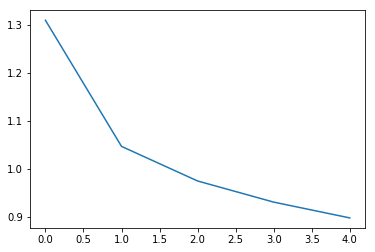

                   m       v       e |  sens   acc
music         242926       0     720 |  1.00  0.70
voice         157464       0   86783 |  0.00  0.68
environment    70096       0  196340 |  0.74  0.79
--------------------------------------
prec            0.52    0.00    0.69

F1 overall: 0.46
F1 music: 0.68
F1 voice: 0.00
F1 environment: 0.71



In [23]:
layersList = [[400, 250, 100, 20]]
nrEpochs = 5
nrsEpochs = range(1, nrEpochs + 1)
bSize = 800000
for layers in layersList:
    LOG_HEADER(logPrefix + ', lagen: {}'.format(str(layers)), True)
    train_and_evaluate_model(X_train, Y_train, realTrainClasses, 
                                 layers, nrEpochs, modelFilePath, baseModelFilename,
                                batch_size=bSize)

####################################
#
# Orgs G428 en G527, lagen: [400, 250, 100, 20]
#
####################################

Start: 13:12:00
Epoch 1/5
754329/754329 [==============================] - 25s 32us/step - loss: 0.1332 - acc: 0.9503
Epoch 2/5
754329/754329 [==============================] - 24s 32us/step - loss: 0.0812 - acc: 0.9694
Epoch 3/5
754329/754329 [==============================] - 24s 31us/step - loss: 0.0705 - acc: 0.9732
Epoch 4/5
754329/754329 [==============================] - 24s 32us/step - loss: 0.0640 - acc: 0.9758
Epoch 5/5
754329/754329 [==============================] - 24s 32us/step - loss: 0.0608 - acc: 0.9768

End: 13:14:00
Time taken: 
0:02:00.209036



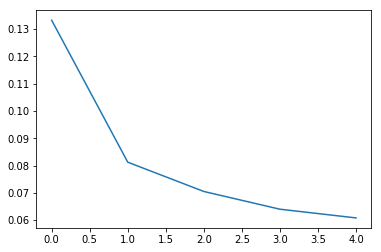

                   m       v       e |  sens   acc
music         238727    4703     216 |  0.98  0.99
voice           6163  234637    3447 |  0.96  0.98
environment      212    2097  264127 |  0.99  0.99
--------------------------------------
prec            0.97    0.97    0.99

F1 overall: 0.98
F1 music: 0.98
F1 voice: 0.97
F1 environment: 0.99



In [24]:
bSize = 128
for layers in layersList:
    LOG_HEADER(logPrefix + ', lagen: {}'.format(str(layers)), True)
    train_and_evaluate_model(X_train, Y_train, realTrainClasses, 
                                 layers, nrEpochs, modelFilePath, baseModelFilename,
                                batch_size=bSize)

####################################
#
# Orgs G428 en G527, lagen: [400, 250, 100, 20]
#
####################################

Start: 13:15:05
Epoch 1/5
754329/754329 [==============================] - 5s 6us/step - loss: 0.2390 - acc: 0.9121
Epoch 2/5
754329/754329 [==============================] - 4s 5us/step - loss: 0.1242 - acc: 0.9544
Epoch 3/5
754329/754329 [==============================] - 4s 5us/step - loss: 0.0996 - acc: 0.9628
Epoch 4/5
754329/754329 [==============================] - 4s 5us/step - loss: 0.0844 - acc: 0.9682
Epoch 5/5
754329/754329 [==============================] - 4s 5us/step - loss: 0.0767 - acc: 0.9711

End: 13:15:26
Time taken: 
0:00:21.638868



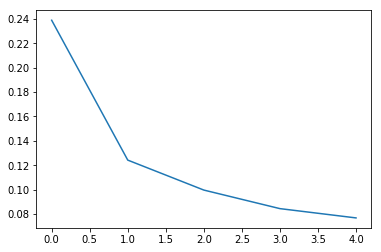

                   m       v       e |  sens   acc
music         233843    9641     162 |  0.96  0.98
voice           2951  238580    2716 |  0.98  0.97
environment      341    5344  260751 |  0.98  0.99
--------------------------------------
prec            0.99    0.94    0.99

F1 overall: 0.97
F1 music: 0.97
F1 voice: 0.96
F1 environment: 0.98



In [25]:
bSize = 2048
for layers in layersList:
    LOG_HEADER(logPrefix + ', lagen: {}'.format(str(layers)), True)
    train_and_evaluate_model(X_train, Y_train, realTrainClasses, 
                                 layers, nrEpochs, modelFilePath, baseModelFilename,
                                batch_size=bSize)

####################################
#
# Orgs G428 en G527, lagen: [400, 250, 100, 20]
#
####################################

Start: 13:16:13
Epoch 1/10
754329/754329 [==============================] - 5s 6us/step - loss: 0.2463 - acc: 0.9049
Epoch 2/10
754329/754329 [==============================] - 4s 5us/step - loss: 0.1294 - acc: 0.9530
Epoch 3/10
754329/754329 [==============================] - 4s 5us/step - loss: 0.1043 - acc: 0.9615
Epoch 4/10
754329/754329 [==============================] - 4s 5us/step - loss: 0.0899 - acc: 0.9664
Epoch 5/10
754329/754329 [==============================] - 4s 5us/step - loss: 0.0797 - acc: 0.9700
Epoch 6/10
754329/754329 [==============================] - 4s 5us/step - loss: 0.0722 - acc: 0.9727
Epoch 7/10
754329/754329 [==============================] - 4s 5us/step - loss: 0.0667 - acc: 0.9747
Epoch 8/10
754329/754329 [==============================] - 4s 5us/step - loss: 0.0643 - acc: 0.9757
Epoch 9/10
754329/754329 [=======================

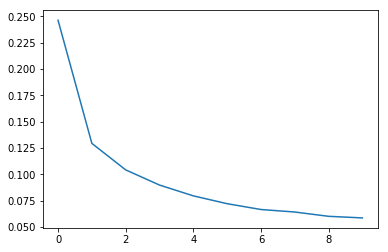

                   m       v       e |  sens   acc
music         238821    4684     141 |  0.98  0.99
voice           4685  236484    3078 |  0.97  0.98
environment      183    3091  263162 |  0.99  0.99
--------------------------------------
prec            0.98    0.97    0.99

F1 overall: 0.98
F1 music: 0.98
F1 voice: 0.97
F1 environment: 0.99



In [26]:
nrEpochs = 10
nrsEpochs = range(1, nrEpochs + 1)
bSize = 2048
for layers in layersList:
    LOG_HEADER(logPrefix + ', lagen: {}'.format(str(layers)), True)
    train_and_evaluate_model(X_train, Y_train, realTrainClasses, 
                                 layers, nrEpochs, modelFilePath, baseModelFilename,
                                batch_size=bSize)

In [30]:
# Test alle modellen
testModel(modelFilePath=storageFolder, 
             layers=layers, 
             micNr=4, 
             testFileNames=['testData_G428', 'testData_G527', 'testData_Studio'],
             nrEpochs=nrEpochs,
             showOverall=True)   

####################################
#
# 20180829_speedTest_400_250_100_20ep10
# mic4
# testData_G428
#
####################################

                   m       v       e |  sens   acc
music          19793     807      39 |  0.96  0.97
voice            454   13781     201 |  0.95  0.97
environment       16     143   13066 |  0.99  0.99
--------------------------------------
prec            0.98    0.94    0.98

F1 overall: 0.97
F1 music: 0.97
F1 voice: 0.94
F1 environment: 0.98

####################################
#
# 20180829_speedTest_400_250_100_20ep10
# mic4
# testData_G527
#
####################################

                   m       v       e |  sens   acc
music           8797     117       3 |  0.99  0.98
voice            110    2751       5 |  0.96  0.98
environment        0       3    2488 |  1.00  1.00
--------------------------------------
prec            0.99    0.96    1.00

F1 overall: 0.98
F1 music: 0.99
F1 voice: 0.96
F1 environment: 1.00

################